# CLIP-ReID -- Wyscout Global Football

* We can train the CLIP-ReID on the basketball data provided
* Let's try to get it to train on our own global football images
* Too sparse to look to focus flex video
* We do have a very large wyscout global football dataset

https://quilt3.hudltools.com/b/hudlrd-datasets/packages/hudlrd/global_football_reid_wyscout

## Procedure

1. Sync all the images from the dataset
2. Load up the quilt dataset parquet file
3. Grab about 500 unique person IDs
4. Filter out some max box_iou value
4. Grab the bbox clips of them and put them in the format `<person_id>_<game_id>_<frame_id>.jpeg` into the `data/data_wyscout_reid/reid_training` directory
5. Grab 50 more unique person IDs
6. Put their 0th frame in the `data/data_wyscout_reid/reid_test/query` dir, put the rest in the `gallery`
7. Train!
8. See if I can also implement the `mAP@R` metric so we can compare with past results on the wyscout dataset.

In [32]:
import os
from pathlib import Path
import random
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from hudl_aws.s3 import S3Location, read_from_s3

random.seed(42)

WORKING_DIR = Path().resolve()
WYSCOUT_DATA_DIR = WORKING_DIR / "data" / "data_wyscout_reid"
WYSCOUT_RAW_IMAGE_DIR = WYSCOUT_DATA_DIR / "raw"

TRAIN_SIZE = 500
TEST_SIZE = 50

In [14]:
df = pd.read_parquet("reid_wyscout.parquet")

# Only look at images that have < 0.15 box_iou
df = df[df["box_iou"] < 0.15]

# Only keep video/id pairs that have at least 20 frames
df = df.groupby(["video_id", "id"]).filter(lambda x: len(x) >= 20)

# Get unique video/id pairs
unique_video_and_id = df[["video_id", "id"]].drop_duplicates()

In [20]:
# Pick 500 for training and 50 for testing with no repeated players in either set
unique_player_ids = unique_video_and_id["id"].unique().tolist()
random.shuffle(unique_player_ids)

train_player_ids = unique_player_ids[:TRAIN_SIZE]
test_player_ids = unique_player_ids[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]

# Grab the first video/id pair for each id
train_video_and_id = (
    unique_video_and_id[
        unique_video_and_id["id"]
        .isin(train_player_ids)
    ]
    .groupby("id")
    .first()
    .reset_index()
)
test_video_and_id = (
    unique_video_and_id[
        unique_video_and_id["id"]
        .isin(test_player_ids)
    ]
    .groupby("id")
    .first()
    .reset_index()
)

In [22]:
train_video_and_id

,id,video_id
0,77,2753566
1,145,5241705
2,159,5151480
3,354,2809543
4,370,5235065
...,...,...
495,15127778,5251216
496,15211411,2809543
497,15874439,2737385
498,16018838,2843682


In [23]:
# Compile the selected frames into a dataframe for training and testing
train_df = pd.DataFrame()
for i, (id, video_id) in enumerate(train_video_and_id.values):
    train_df = pd.concat([train_df, df[(df["video_id"] == video_id) & (df["id"] == id)].sample(20)])

test_df = pd.DataFrame()
for i, (id, video_id) in enumerate(test_video_and_id.values):
    test_df = pd.concat([test_df, df[(df["video_id"] == video_id) & (df["id"] == id)].sample(20)])

In [24]:
video_id = train_video_and_id.iloc[0]["video_id"]
player_id = train_video_and_id.iloc[0]["id"]

In [25]:
# Peek at the 20 selected frames for a video/id pair
single_df = train_df[(train_df["video_id"] == video_id) & (train_df["id"] == player_id)].copy()
single_df

,gender,video_id,relative_frame_index,absolute_frame_index,s3_frame_img_path,s3_video_path,id,original_id,team,original_team,original_box,box_iou
1919351,male,2753566,188,71638,s3://hudlrd-experiments/py-calibrate/global_fo...,s3://hudlrd-experiments/py-calibrate/global_fo...,77,218,2443,2,"[1577.62, 538.51, 33.5, 81.17]",0.000000
1938402,male,2753566,157,41782,s3://hudlrd-experiments/py-calibrate/global_fo...,s3://hudlrd-experiments/py-calibrate/global_fo...,77,218,2443,2,"[910.06, 285.84, 31.925, 63.790000000000006]",0.050786
1927425,male,2753566,728,72178,s3://hudlrd-experiments/py-calibrate/global_fo...,s3://hudlrd-experiments/py-calibrate/global_fo...,77,218,2443,2,"[1585.04, 533.18, 28.49, 73.89]",0.000000
1934967,male,2753566,664,55864,s3://hudlrd-experiments/py-calibrate/global_fo...,s3://hudlrd-experiments/py-calibrate/global_fo...,77,218,2443,2,"[564.77, 270.24, 54.84, 72.52000000000001]",0.000000
1927161,male,2753566,716,72166,s3://hudlrd-experiments/py-calibrate/global_fo...,s3://hudlrd-experiments/py-calibrate/global_fo...,77,218,2443,2,"[1548.54, 516.24, 27.14, 82.75]",0.135111
1919371,male,2753566,189,71639,s3://hudlrd-experiments/py-calibrate/global_fo...,s3://hudlrd-experiments/py-calibrate/global_fo...,77,218,2443,2,"[1581.3049999999998, 538.06, 33.94, 82.3849999...",0.000000
1939518,male,2753566,214,41839,s3://hudlrd-experiments/py-calibrate/global_fo...,s3://hudlrd-experiments/py-calibrate/global_fo...,77,218,2443,2,"[635.8, 296.24, 37.68, 68.55]",0.000000
1940138,male,2753566,245,41870,s3://hudlrd-experiments/py-calibrate/global_fo...,s3://hudlrd-experiments/py-calibrate/global_fo...,77,218,2443,2,"[450.385, 318.275, 39.5, 69.755]",0.000000
1934991,male,2753566,666,55866,s3://hudlrd-experiments/py-calibrate/global_fo...,s3://hudlrd-experiments/py-calibrate/global_fo...,77,218,2443,2,"[564.51, 268.76, 56.38, 72.54999999999998]",0.000000
1928476,male,2753566,31,55231,s3://hudlrd-experiments/py-calibrate/global_fo...,s3://hudlrd-experiments/py-calibrate/global_fo...,77,218,2443,2,"[471.445, 180.34, 24.689999999999998, 56.595]",0.000000


In [31]:
def get_image(s3_img_path: Path) -> None:
    """Downloads the s3 image if it doesn't already exist"""
    img_path = WYSCOUT_RAW_IMAGE_DIR / s3_img_path.split("images/")[1]
    if not img_path.exists():
        os.makedirs(os.path.dirname(img_path), exist_ok=True)
        s3_location = S3Location.from_path(s3_img_path)
        with open(img_path, "wb") as f:
            f.write(read_from_s3(**s3_location).read())

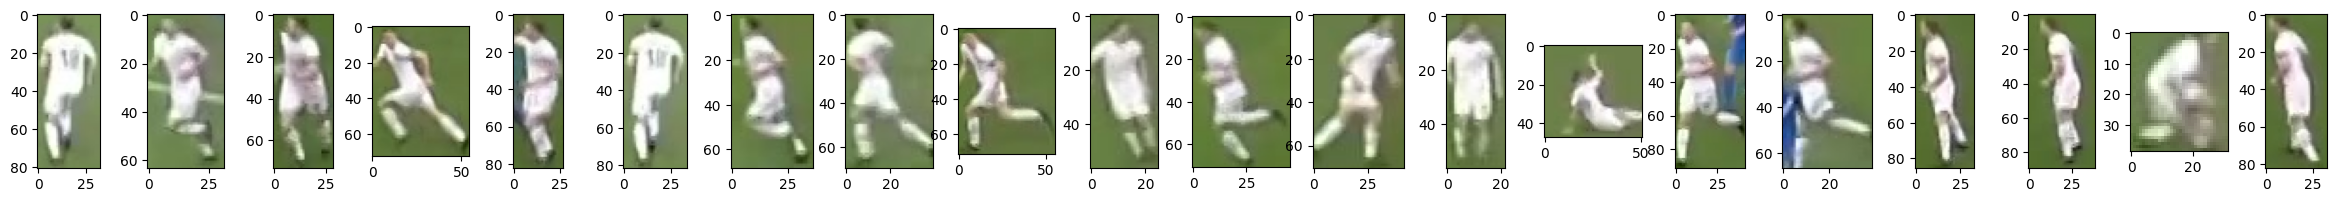

In [27]:
# Let's pull these images and crop them to the bboxes and look at them
fig, axs = plt.subplots(1, len(single_df), figsize=(30, 2))
i = 0
for _, row in single_df.iterrows():
    s3_img_path = row["s3_frame_img_path"]
    get_image(s3_img_path)
    img_path = WYSCOUT_RAW_IMAGE_DIR / s3_img_path.split("images/")[1]
    assert img_path.exists()
    img = plt.imread(img_path)
    bbox_xywh = row["original_box"]
    bbox_xywh = [float(x) for x in bbox_xywh[1:-1].split(",")]
    img = img[
        int(round(bbox_xywh[1])):int(round(bbox_xywh[1] + bbox_xywh[3])),
        int(round(bbox_xywh[0])):int(round(bbox_xywh[0] + bbox_xywh[2]))
    ]
    axs[i].imshow(img)
    i += 1

In [39]:
for _, row in tqdm(train_df.iterrows(), total=len(train_df), ncols=100):
    s3_img_path = row["s3_frame_img_path"]
    get_image(s3_img_path)
    img_path = WYSCOUT_RAW_IMAGE_DIR / s3_img_path.split("images/")[1]
    new_image_path = (
        WYSCOUT_DATA_DIR / 
        "reid_training" /
        f"{row['id']:08d}_{row['video_id']:08d}_{row['absolute_frame_index']:08d}.jpeg"
    )
    if not new_image_path.exists():
        try:
            img = plt.imread(img_path)
            bbox_xywh = row["original_box"]
            bbox_xywh = [float(x) for x in bbox_xywh[1:-1].split(",")]
            img = img[
                max(0, int(round(bbox_xywh[1]))):int(round(bbox_xywh[1] + bbox_xywh[3])),
                max(0, int(round(bbox_xywh[0]))):int(round(bbox_xywh[0] + bbox_xywh[2]))
            ]
            os.makedirs(os.path.dirname(new_image_path), exist_ok=True)
            plt.imsave(new_image_path, img)
        except:
            print(row)

 70%|████████████████████████████████████████▉                 | 7049/10000 [01:32<00:37, 79.71it/s]

gender                                                               male
video_id                                                          5151480
relative_frame_index                                                   92
absolute_frame_index                                                51042
s3_frame_img_path       s3://hudlrd-experiments/py-calibrate/global_fo...
s3_video_path           s3://hudlrd-experiments/py-calibrate/global_fo...
id                                                                 388267
original_id                                                           209
team                                                                 2446
original_team                                                           2
original_box                    [25.83, 123.58000000000001, 29.06, 72.06]
box_iou                                                               0.0
Name: 1332656, dtype: object


100%|█████████████████████████████████████████████████████████| 10000/10000 [02:10<00:00, 76.45it/s]


In [40]:
seen = set()
for _, row in tqdm(test_df.iterrows(), total=len(test_df), ncols=100):
    s3_img_path = row["s3_frame_img_path"]
    get_image(s3_img_path)
    img_path = WYSCOUT_RAW_IMAGE_DIR / s3_img_path.split("images/")[1]

    if row['id'] in seen:
        query_or_gallery = "gallery"
    else:
        query_or_gallery = "query"
        seen.add(row['id'])

    new_image_path = (
        WYSCOUT_DATA_DIR / 
        "reid_test" /
        query_or_gallery /
        f"{row['id']:08d}_{row['video_id']:08d}_{row['absolute_frame_index']:08d}.jpeg"
    )
    
    if not new_image_path.exists():
        try:
            img = plt.imread(img_path)
            bbox_xywh = row["original_box"]
            bbox_xywh = [float(x) for x in bbox_xywh[1:-1].split(",")]
            img = img[
                max(0, int(round(bbox_xywh[1]))):int(round(bbox_xywh[1] + bbox_xywh[3])),
                max(0, int(round(bbox_xywh[0]))):int(round(bbox_xywh[0] + bbox_xywh[2]))
            ]
            os.makedirs(os.path.dirname(new_image_path), exist_ok=True)
            plt.imsave(new_image_path, img)
        except:
            print(row)

100%|███████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 76.35it/s]
